In [1]:
import numpy as np

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
import h5py
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.models import Model
from keras.applications.resnet50 import preprocess_input
from keras.layers.core import Dense, Dropout, Flatten
from keras.preprocessing import image
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
# from keras.layers.normalization import BatchNormalization
# from keras.optimizers import Adam
from keras import optimizers
from keras.utils import np_utils
from keras.models import model_from_json
# from sklearn.metrics import log_loss
from numpy.random import permutation
from sklearn import preprocessing
%matplotlib inline
from matplotlib import pyplot as plt
np.random.seed(2016)
use_cache = 1

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#以RGB形式获取一张图像并预处理（减去RGB均值）
def get_im(path, img_rows=224, img_cols=224):
    img = image.load_img(path, target_size=(img_rows, img_cols))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = x[0]
    return x

In [3]:
#从driver_imgs_list.csv获取（图像文件名-司机id）字典
def get_driver_data():
    dr = dict()
    path = os.path.join('.', 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr

In [4]:
#以ndarray形式加载训练集,并对标签进行独热编码
def load_train(img_rows=224, img_cols=224):
    X_train = []
    y_train = []
    driver_id = []

    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join('.', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im(fl, img_rows, img_cols)
            X_train.append(img)
            y_train.append(j)
            driver_id.append(driver_data[flbase])
    
    one_hot_encoder = preprocessing.OneHotEncoder(n_values=10)
    y_train = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return np.array(X_train, dtype='float32'), np.array(y_train, dtype='float32'), driver_id, unique_drivers

In [5]:
#分离出某些司机数据作为验证集
def train_val_split(driver_val, driver_id, X, y):
    val = []
    tra = [a for a in range(len(X))]
    assert (len(driver_id) == len(X)) & (len(driver_id) == len(y))
    
    for a in range(len(X)):
        if driver_id[a] in driver_val:
            val.append(a)
    X_val = np.array([X[a] for a in val], dtype='float32')
    y_val = np.array([y[a] for a in val], dtype='float32')
    
    for a in val:
        tra.remove(a)
    X_train = np.array([X[a] for a in tra], dtype='float32')
    y_train = np.array([y[a] for a in tra], dtype='float32')
    
    return X_train, y_train, X_val, y_val

In [6]:
#以ndarray形式加载测试集
def load_test_generator(batch_size, img_rows=224, img_cols=224):
    print('Read test images')
    path = os.path.join('.', 'test', '*.jpg')
    files = glob.glob(path)[:]
    X_test = []
    steps = 1
    while(steps <= math.ceil(len(files)/batch_size)):
        start = steps*batch_size
        end = min(len(files), start+batch_size)
    
        for fl in files[start:end]:
            flbase = os.path.basename(fl)
            img = get_im(fl, img_rows, img_cols)
            X_test.append(img)
        steps += 1
        yield np.array(X_test, dtype='float32')

In [7]:
def get_X_text_id():
    path = os.path.join('.', 'test', '*.jpg')
    files = glob.glob(path)
    X_test_id = []
    for fl in files:
        flbase = os.path.basename(fl)
        X_test_id.append(flbase)
    return X_test_id

In [10]:
def read_train_and_val_data(img_rows, img_cols):

    cache_path = os.path.join('cache', 'train_r_' + str(img_rows) +
                              '_c_' + str(img_cols) + '_t_' +
                              str(3) + '.dat')

    if not os.path.isfile(cache_path) or use_cache == 0:
        X_train, y_train, driver_id, unique_drivers = load_train(img_rows, img_cols)
        cache_data((X_train, y_train, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (X_train, y_train, driver_id, unique_drivers) = restore_data(cache_path)
    driver_val = ['p026','p035','p039','p041']
    X_train, y_train, X_val, y_val = train_val_split(driver_val, driver_id, X_train, y_train)
    print('Train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    return X_train, y_train, X_val, y_val

In [11]:
#对数据随机排序并划分batch
def shuffle_and_batch(batch_size, X_train, y_train):
    r = np.random.permutation(len(X_train))
    new_X_train, new_y_train = X_train[r,:,:,:], y_train[r,:]
    for start in range(0, len(new_X_train), batch_size):
        end = min(start + batch_size, len(X_train))
        yield np.array(new_X_train[start:end], dtype='float32'), np.array(new_y_train[start: end], dtype='float32')

In [12]:
def vgg_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [13]:
def resnet():
    base_model = ResNet50(include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    adam = optimizers.Adam(lr=0.0008, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    for layer in model.layers[:4]:
        layer.trainable = False
    for layer in model.layers[4:]:
        layer.trainable = True
    
    #for i, layer in enumerate(model.layers):
    #    print(i, layer.name)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
def fit_and_in_fold(X_raw, y_raw, model, folds, epochs, batch_size, modelname=''):
    kf = KFold(folds, shuffle=True)

    if not os.path.isdir('cache'):
        os.mkdir('cache')
    
    for train_idx, val_idx in kf.split(unique_drivers):
        fold=1
        driver_val = [unique_drivers[a] for a in val_idx]
        X_train, y_train, X_val, y_val = train_val_split(driver_val, driver_id, X_raw, y_raw)
        
        res = resnet()
        res.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val), shuffle=True)

        json_string = model.to_json()
        with open(os.path.join('cache',modelname + str(fold) + '.json'), 'w') as f:
            f.write(json_string)
        weight = model.save_weights(os.path.join('cache', modelname + str(fold) + '.h5'), overwrite=True)
        fold+=1

        

In [ ]:
def predict_with_generator(generator, ):
    predicts=[]
    ge = load_test_generator(64, img_rows=224, img_cols=224)
    
    predict = model.predict_generator(generator=ge, steps=1246, verbose=1)
    predicts.append[predict]

In [14]:
X_raw, y_raw, driver_id, unique_drivers = load_train(224, 224)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


In [15]:
res = resnet()

In [17]:
ge = load_test_generator(16, img_rows=224, img_cols=224)

In [ ]:
#steps=1246

In [18]:
b = res.predict_generator(generator=ge, steps=120, verbose=1)

Read test images
 40/120 [=========>....................] - ETA: 6:35

ResourceExhaustedError: OOM when allocating tensor with shape[656,256,55,55] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: bn2a_branch2c/FusedBatchNorm = FusedBatchNorm[T=DT_FLOAT, data_format="NHWC", epsilon=0.001, is_training=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](res2a_branch2c/BiasAdd, bn2a_branch2c/gamma/read, bn2a_branch2c/beta/read, bn5c_branch2a/Const_4, bn5c_branch2a/Const_4)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: dense_3/Softmax/_2365 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2711_dense_3/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'bn2a_branch2c/FusedBatchNorm', defined at:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-981eb636afa2>", line 1, in <module>
    res = resnet()
  File "<ipython-input-13-5071c12aa77e>", line 2, in resnet
    base_model = ResNet50(include_top=False, weights='imagenet')
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/applications/resnet50.py", line 219, in ResNet50
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/applications/resnet50.py", line 118, in conv_block
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/layers/normalization.py", line 181, in call
    epsilon=self.epsilon)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1827, in normalize_batch_in_training
    epsilon=epsilon)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 1802, in _fused_normalize_batch_in_training
    data_format=tf_data_format)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py", line 906, in fused_batch_norm
    name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 2224, in _fused_batch_norm
    is_training=is_training, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[656,256,55,55] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: bn2a_branch2c/FusedBatchNorm = FusedBatchNorm[T=DT_FLOAT, data_format="NHWC", epsilon=0.001, is_training=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](res2a_branch2c/BiasAdd, bn2a_branch2c/gamma/read, bn2a_branch2c/beta/read, bn5c_branch2a/Const_4, bn5c_branch2a/Const_4)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: dense_3/Softmax/_2365 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2711_dense_3/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [23]:
b.shape

(1536, 10)

In [21]:
a= next(load_test_generator(64, img_rows=224, img_cols=224))

Read test images


In [22]:
a.shape

(64, 224, 224, 3)

In [14]:
#driver_val = ['p026','p035','p039','p041']
#X_train, y_train, X_val, y_val = train_val_split(driver_val, driver_id, X_train, y_train)

In [15]:
r = np.random.permutation(len(X_train))
X_train, y_train = X_train[r,:,:,:], y_train[r,:]

In [16]:
X_train.shape

(19124, 224, 224, 3)

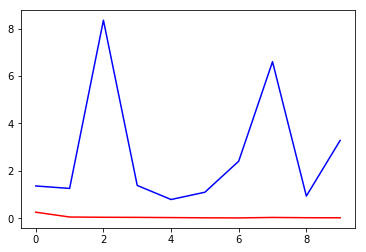

In [32]:
plt.plot(range(10),res_hist.history['loss'],'r',label='loss')
plt.plot(range(10),res_hist.history['val_loss'],'b',label='val_loss')

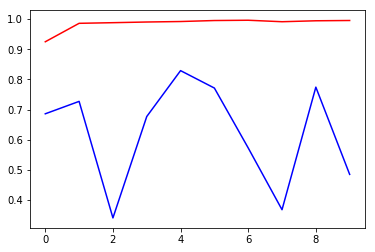

In [33]:
plt.plot(range(10),res_hist.history['acc'],'r',label='acc')
plt.plot(range(10),res_hist.history['val_acc'],'b',label='val_acc')

In [24]:
#json_string = res.to_json()
#os.mkdir('cache')
#open(os.path.join('cache', 'res1'), 'w').write(json_string)
#res.save_weights(os.path.join('cache', 'res1weight'), overwrite=True)

In [ ]:
#batch_size = 64
#steps_per_epoch = int(math.ceil(len(X_train)/batch_size))

In [ ]:
#hist = vgg.fit_generator(shuffle_and_batch(batch_size, X_train, y_train), steps_per_epoch, epochs=10, verbose=1)

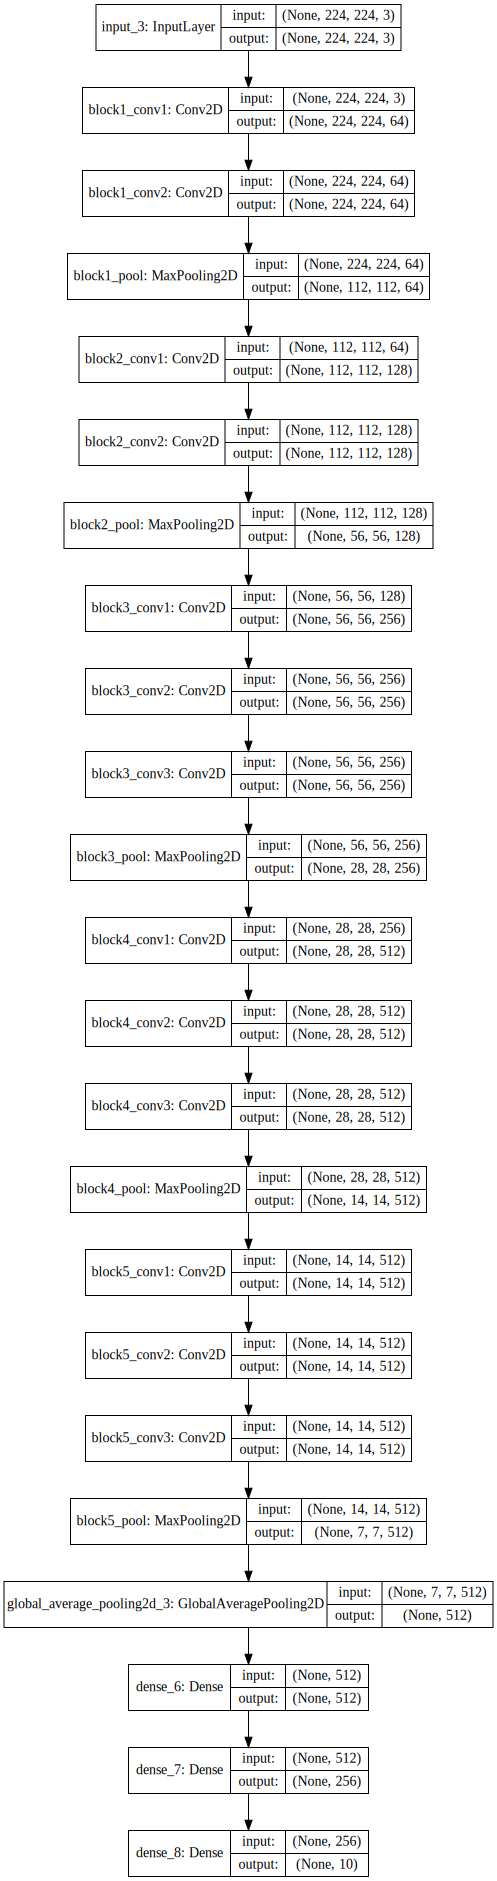

In [37]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
import pydot
import graphviz
plot_model(vgg, show_shapes=True, to_file='model_simple.png')
SVG(model_to_dot(vgg, show_shapes=True).create(prog='dot', format='svg'))